In [2]:
import numpy as np
import pandas as pd
import os
import pathlib as Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import requests
from police_api import PoliceAPI

api = PoliceAPI()

px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")

In [3]:
df_out_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-outcomes.csv')
df_ss_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-stop-and-search.csv')
df_street_2011_02 = pd.read_csv(r'.\\Datasets\\2010-2017\\2011-02\\2011-02-metropolitan-street.csv')
df_street_2011_02[df_street_2011_02['Crime type'] == 'Burglary'].head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
25,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.128330,51.584559,On or near Nash Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
26,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.126964,51.586508,On or near Rowan Way,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
27,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.129225,51.583922,On or near Gregory Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
28,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.131680,51.586432,On or near Newhouse Avenue,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
38,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.139479,51.579743,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Burglary,NaN,NaN


In [4]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [5]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [6]:
street_all_years = pd.concat(all_street_df, ignore_index=True)
print(len(street_all_years))
print(street_all_years['Last outcome category'].isna().sum(), street_all_years['Context'].isna().sum(), street_all_years['Crime ID'].isna().sum())
df_clean = street_all_years.drop(columns=['Context'])
df_clean = df_clean.dropna().reset_index(drop=True)
burglary_data = df_clean.loc[(df_clean['Crime type'] == 'Burglary') & (df_clean['LSOA name'].str.contains("Barnet"))]
print(burglary_data.head())


5446734
1408520 5446734 1408520
                                               Crime ID    Month  \
1378  baf93686441a8974b2cd51587e7227d5ab3012618a0a2d...  2012-02   
1392  b2748d9e7e2b41c073d962852eadc546a01a8f8db687a2...  2012-02   
1393  5441dcd2b2647533fd8ae6fbeb897002209401dc63892b...  2012-02   
1394  593356ce1bdb2fdf464bb4b8667c0e784ae271969eccd3...  2012-02   
1395  ae6406a078ebe24c0225a14d48d85becf01ef632c724a5...  2012-02   

                      Reported by                 Falls within  Longitude  \
1378  Metropolitan Police Service  Metropolitan Police Service  -0.205064   
1392  Metropolitan Police Service  Metropolitan Police Service  -0.209422   
1393  Metropolitan Police Service  Metropolitan Police Service  -0.210051   
1394  Metropolitan Police Service  Metropolitan Police Service  -0.211600   
1395  Metropolitan Police Service  Metropolitan Police Service  -0.209422   

       Latitude                   Location  LSOA code    LSOA name Crime type  \
1378  51.657214

In [7]:
fig = ff.create_hexbin_mapbox(
            data_frame=burglary_data, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [14]:
df_groups = burglary_data.groupby(['Month']).count()
df_groups

,Crime ID,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
Month,,,,,,,,,,
2012-02,424,424,424,424,424,424,424,424,424,424
2012-03,432,432,432,432,432,432,432,432,432,432
2012-08,400,400,400,400,400,400,400,400,400,400
2012-09,347,347,347,347,347,347,347,347,347,347
2012-12,375,375,375,375,375,375,375,375,375,375
2013-10,332,332,332,332,332,332,332,332,332,332
2014-02,294,294,294,294,294,294,294,294,294,294
2014-09,294,294,294,294,294,294,294,294,294,294
2014-12,320,320,320,320,320,320,320,320,320,320


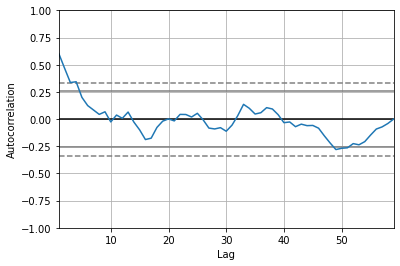

In [15]:
import matplotlib.pyplot as plt

s = df_groups['Crime ID']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

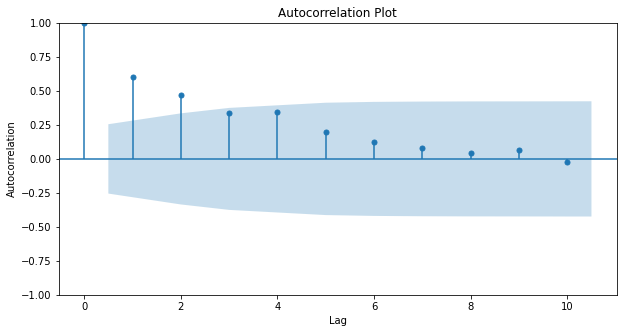

In [16]:
import statsmodels.api as sm

# Compute autocorrelation
acf = sm.tsa.stattools.acf(df_groups['Crime ID'], nlags=10)

# Plot autocorrelation
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(df_groups['Crime ID'], lags=10, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Plot')
plt.show()

predicted=357.499786, expected=328.000000
predicted=313.066244, expected=286.000000
predicted=302.130390, expected=296.000000
predicted=309.396181, expected=289.000000
predicted=301.795465, expected=281.000000
predicted=279.202654, expected=227.000000
predicted=256.004163, expected=270.000000
predicted=263.379090, expected=275.000000
predicted=272.059191, expected=312.000000
predicted=272.194608, expected=346.000000
predicted=320.244053, expected=243.000000
predicted=282.022502, expected=202.000000
predicted=245.438140, expected=218.000000
predicted=259.059151, expected=171.000000
predicted=195.148200, expected=218.000000
predicted=203.873397, expected=195.000000
predicted=206.281865, expected=190.000000
predicted=185.876049, expected=171.000000
predicted=186.876945, expected=248.000000
predicted=217.072041, expected=246.000000
predicted=232.451136, expected=228.000000
Test RMSE: 43.175


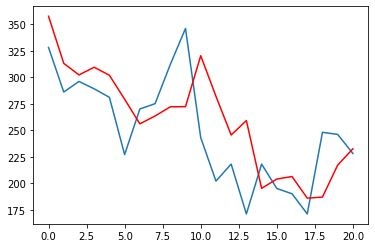

In [21]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = df_groups['Crime ID'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [42]:
# response = requests.get("https://data.police.uk/api/metropolitan/neighbourhoods")
# print(response.status_code)
# The LSOA code from the street df is wrong
LSOA_codes = burglary_data['LSOA code'].unique()
zipped_tuple = tuple(zip(burglary_data['Latitude'], burglary_data['Longitude']))
burglary_data['New LSOA code'] = [api.locate_neighbourhood(*a) for a in zipped_tuple]
print(burglary_data.head())




ValueError: tuple.index(x): x not in tuple

In [26]:
from police_api import PoliceAPI
api = PoliceAPI()

n = api.locate_neighbourhood(51.657214, -0.205064)
n

<Neighbourhood> E05013644